In [1]:
##### import stuff ###### 
import numpy as np 
import pandas as pd 
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt 
import random
import fns as f

In [2]:
class PyCipio:
    def __init__(self, data, time, values, index = None, split = 0.7):
        
        ### specify data
        
        self.df = data
        self.index_codes = "idx_code"
        self.time_codes = "t_code"
        self.time = time
        
        ## handling idx if missing
        if index == None: 
            self.df[index] = np.zeros(len(self.df))
            self.df[self.index_codes] = np.zeros(len(self.df))
        
       ## create idx codes
        self.df[self.index_codes] = pd.Categorical(self.df[index]).codes

        ## handling time 
        if type(self.df[time]) != int:
            self.df[time] = pd.to_datetime(self.df[time])
            self.df[self.time_codes] = self.df.groupby([index]).cumcount()+0
            
        self.train, self.test = f.train_test(self.df, self.time_codes, train_size = split)
        
        ### INIT FOR VALUES IN TEST AND TRAIN:
        
        ## variables for test 
        self.t1_test = ((self.test[self.time_codes] - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())).values
        self.t2_test = np.unique(self.t1_test)
        self.t3_test = len(self.t2_test)
        self.y_test = ((self.test[values] - self.train[values].min()) / (self.train[values].max() - self.train[values].min())).values
        self.idx_test = self.test[self.index_codes].values
        self.n_test = len(np.unique(self.idx_test))

        ## variables for train
        self.t1_train = ((self.train[self.time_codes] - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())).values
        self.t2_train = np.unique(self.t1_train) 
        self.t3_train = len(self.t2_train)
        self.y_train = ((self.train[values] - self.train[values].min()) / (self.train[values].max() - self.train[values].min())).values
        self.idx_train = self.train[self.index_codes].values
        self.n_train = len(np.unique(self.idx_train))
        
    def seasonal_component(
        self,
        name, 
        name_beta, 
        mu, 
        sd, 
        beta_sd, 
        n_components, 
        shape,
        t1,
        t2,
        t3,
        mode):

        p = pm.Beta(name, 
                    mu = mu, 
                    sd = sd, 
                    shape = shape)

        period_x = 2*np.pi*np.arange(1, n_components+1)
        period_stack_x = np.stack([period_x for i in range(shape)])
        period_scaled_x = period_stack_x.T / p
        x = tt.reshape(period_scaled_x[:, :, None] * t2, (n_components, shape*t3))
        x_waves = tt.concatenate((tt.cos(x), tt.sin(x)), axis = 0)

        beta_waves = pm.Normal(
            name_beta, 
            mu = 0,
            sd = beta_sd, 
            shape = (2*n_components, shape))

        ### flatten waves
        lst = []
        index_first = 0
        index_second = t3
        for i in range(shape): 
            tmp = pm.math.dot(x_waves.T[index_first:index_second, :], beta_waves[:, i])
            lst.append(tmp)
            index_first += t3
            index_second += t3
        stacked = tt.stack(lst)
        x_flat = tt.flatten(stacked)

        if mode == "multiplicative":
            x_flat = x_flat * t1


        return (beta_waves, x_waves, x_flat)
        
    def fit(self, p1, p2, p1_mode, p2_mode):
        ## NB: we assume that input is in days. 

        ## common across week & month (I guess)
        ## NB: deviation might as well just go in on each place then.
        divisor = 7
        deviation = 0.2

        ## p1
        p1_mu, p1_components = p1
        p1_sd = p1_mu/divisor

        ## normalize week.
        p1_mu = (p1_mu - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        p1_sd = (p1_sd - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        beta_p1_sd = deviation

        ## p2
        p2_mu, p2_components = p2
        p2_sd = p2_mu/divisor

        ## normalize month.
        p2_mu = (p2_mu -  self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        p2_sd = (p2_sd - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        beta_p2_sd = deviation
        
        with pm.Model() as m0: 
            # shared 
            t1_shared = pm.Data('t1_shared', self.t1_train)
            t2_shared = pm.Data('t2_shared', self.t2_train)
            t3_shared = pm.Data('t3_shared', np.array(self.t3_train))
            idx_shared = pm.Data('idx_shared', self.idx_train)

            # prepare fourier week
            #seasonal_component(name, name_beta, mu, sd, beta_sd, n_components, shape, time_scaled)
            beta_p1_waves, x_p1_waves, p1_flat = self.seasonal_component(name = "p1",
                                                               name_beta = "beta_p1_waves",
                                                               mu = p1_mu,
                                                               sd = p1_sd,
                                                               beta_sd = beta_p1_sd,
                                                               n_components = p1_components,
                                                               shape = self.n_train,
                                                               t1 = t1_shared,
                                                               t2 = t2_shared,
                                                               t3 = t3_shared, 
                                                                    mode = p1_mode)

            beta_p2_waves, x_p2_waves, p2_flat = self.seasonal_component(name = "p2",
                                                               name_beta = "beta_p2_waves",
                                                               mu = p2_mu,
                                                               sd = p2_sd,
                                                               beta_sd = beta_p2_sd,
                                                               n_components = p2_components,
                                                               shape = self.n_train,
                                                               t1 = t1_shared,
                                                               t2 = t2_shared,
                                                               t3 = t3_shared, 
                                                                    mode = p2_mode)

            # other priors
            beta_line = pm.Normal('beta_line', mu = 0, sd = 0.3, shape = self.n_train)
            alpha = pm.Normal('alpha', mu = 0.5, sd = 0.3, shape = self.n_train)

            mu = alpha[idx_shared] + beta_line[idx_shared] * t1_shared + p1_flat + p2_flat

            # sigma 
            sigma = pm.Exponential('sigma', 1)

            # likelihood 
            y_pred = pm.Normal(
                'y_pred', 
                mu = mu,
                sd = sigma,
                observed = self.y_train)
    
            self.model = m0
        
    ##### Part 6: Sampling ######

        ## sample prior
        with self.model:
            prior_pred = pm.sample_prior_predictive(100) # like setting this low. 
            m0_idata = az.from_pymc3(prior=prior_pred)

        az.plot_ppc(m0_idata, group="prior")

    ## convenience function 
    def sample_mod(
        self, 
        posterior_draws = 1000, 
        post_pred_draws = 1000,
        prior_pred_draws = 500):

        with self.model: 
            self.trace = pm.sample(
                return_inferencedata = False, 
                draws = posterior_draws,
                target_accept = .95) # tuning!
            self.post_pred = pm.sample_posterior_predictive(self.trace, samples = post_pred_draws)
            self.prior_pred = pm.sample_prior_predictive(samples = prior_pred_draws)
            self.m_idata = az.from_pymc3(trace = self.trace, posterior_predictive=self.post_pred, prior=self.prior_pred)

    def plotting(self):
        ## plot checks 
        az.plot_ppc(self.m_idata, num_pp_samples = 100, group = "prior")
        az.plot_ppc(self.m_idata, num_pp_samples = 100)

        ## plot trace
        az.plot_trace(self.m_idata)
        
    def plot_training(self):
        m_pred = self.m_idata.posterior_predictive.mean(axis = 0)["y_pred"]
        
        ### NOTE: Currently these values are only calculated here, but they are used in predict
        
        self.m_pred_std = m_pred.std(axis = 0).data
        self.m_pred = m_pred.mean(axis = 0).data
        
        ### plot
        # plot them 
        fig, ax = plt.subplots(figsize = (18, 10))
        ax.plot(self.train[self.time].values, self.y_train, label = "data", linewidth = 1.5)
        ax.plot(self.train[self.time].values, self.m_pred, ls="-.", label = "prediction", color = "C3", linewidth = 2)
        ax.fill_between(self.train[self.time].values, 
                        self.m_pred -1.96 * self.m_pred_std, 
                        self.m_pred + 1.96 * self.m_pred_std, 
                        alpha=0.3, 
                        label = "95% confidence interval",
                        color = "C3")
        ax.grid()
        ax.legend()
        
    def predict(self):
        with self.model:
            pm.set_data({"t1_shared": self.t1_test})
            pm.set_data({"t2_shared": self.t2_test})
            pm.set_data({"idx_shared": self.idx_test})
            pm.set_data({"t3_shared": np.array(self.t3_test)})
            self.m_new_pred = pm.fast_sample_posterior_predictive(
                self.m_idata.posterior
            )
        
        ### get values
        self.m_pred_test = self.m_new_pred["y_pred"].mean(axis = 0)
        self.m_pred_test_std = self.m_new_pred["y_pred"].std(axis = 0)
        
        ## plot them (maybe should be in its own function)
        
        # plot them 
        fig, ax = plt.subplots(figsize = (18, 10))
        ax.plot(self.train[self.time].values, self.y_train, label = "data", linewidth = 1.5)
        ax.plot(self.train[self.time].values, self.m_pred, ls="-.", label = "prediction", color = "C3", linewidth = 2)
        ax.fill_between(self.train[self.time].values, 
                        self.m_pred -1.96 * self.m_pred_std, 
                        self.m_pred + 1.96 * self.m_pred_std, 
                        alpha=0.3, 
                        label = "95% confidence interval",
                        color = "C3")

        ax.plot(self.test[self.time].values, self.y_test, linewidth = 1.5, color = "C0")
        ax.plot(self.test[self.time].values, self.m_pred_test, ls="-.", color = "C3", linewidth = 2)
        ax.fill_between(self.test[self.time].values, 
                        self.m_pred_test -1.96 * self.m_pred_test_std, 
                        self.m_pred_test + 1.96 * self.m_pred_test_std, 
                        alpha=0.3,
                        color = "C3")
        ax.axvline(self.train[self.time].values[-1], ls='--', label = "train test split", color = "black")
        ax.grid()
        ax.legend()

    def scale_down(self, x):
        minimum = self.time_true.min()
        maximum = self.time_true.max()
        
        return (x - minimum) / (maximum - minimum)
    
    def scale_up(self, x):
        minimum = self.time_true.min()
        maximum = self.time_true.max()
        
        return (x + minimum) * (maximum - minimum)
    

In [3]:
df = pd.read_csv("../data/archive/Alcohol_Sales.csv")

Pc = PyCipio(df, time = "DATE", values = "S4248SM144NCEN", split = 0.7)

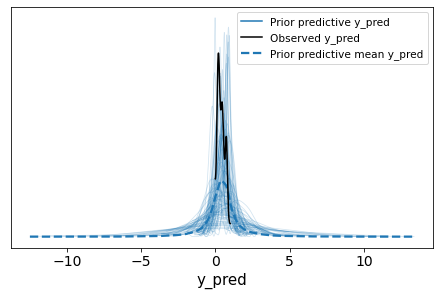

In [4]:
Pc.fit(p1 = (4, 3), p2 = (12, 5), p1_mode = "multiplicative", p2_mode = "multiplicative")

In [5]:
Pc.sample_mod()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta_line, beta_p2_waves, p2, beta_p1_waves, p1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 29164 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


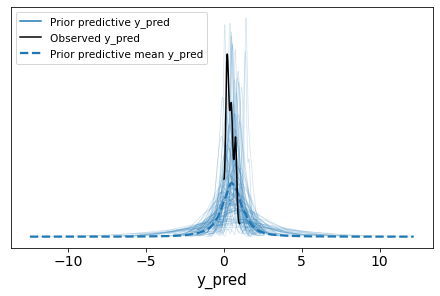

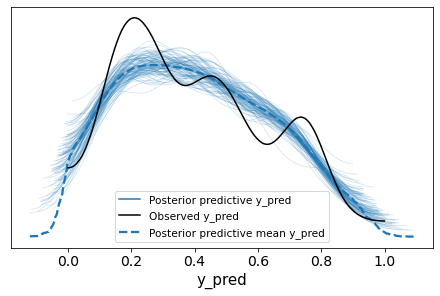

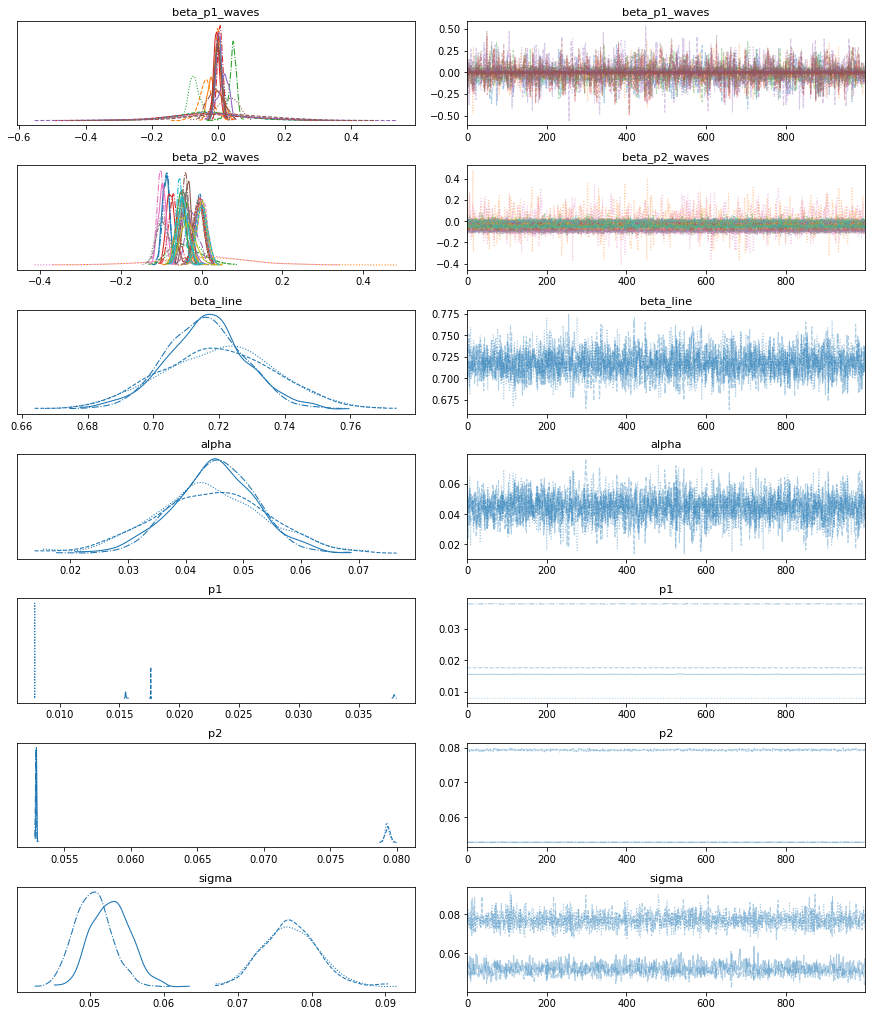

In [68]:
Pc.plotting()

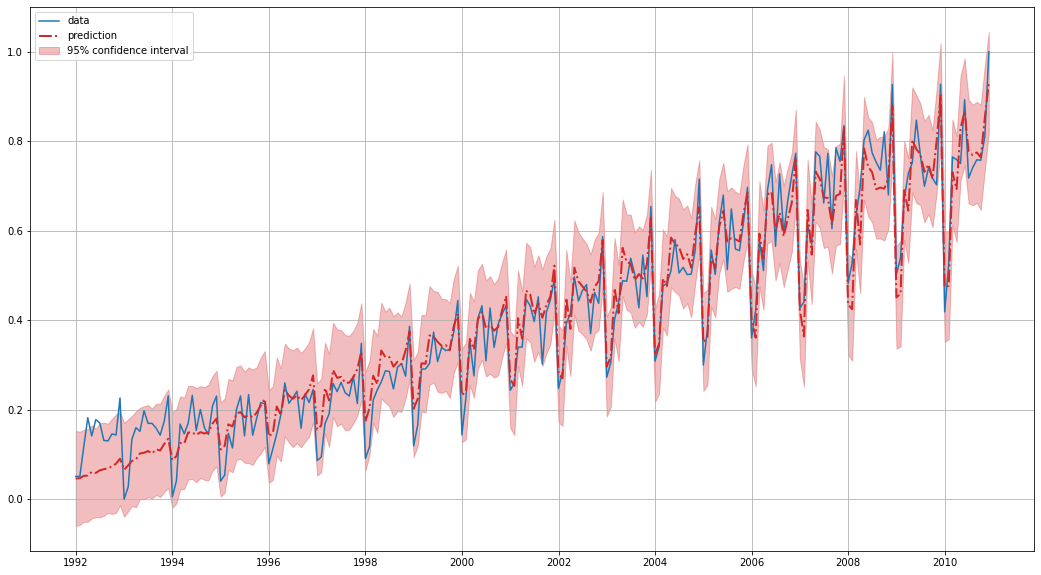

In [69]:
Pc.plot_training()

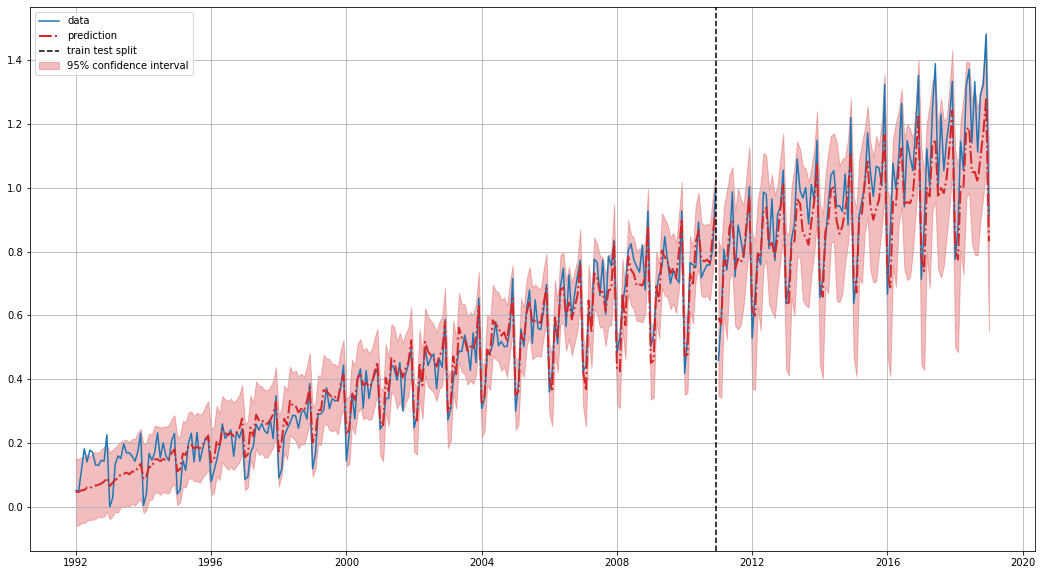

In [70]:
Pc.predict()

In [53]:
##### import stuff ###### 
import numpy as np 
import pandas as pd 
from covid19dh import covid19
from datetime import date
from Get_covid_data import get_data
import pymc3 as pm
import pandas as pd 
import numpy as np 
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import os 
import theano
import theano.tensor as tt 
import random
import fns as f

class PyCipio:
    def __init__(self, data, time, values, index = None, split = 0.7):
        
        ### specify data
        
        self.df = data
        self.index_codes = "idx_code"
        self.time_codes = "t_code"
        self.time = time
        self.index = index
        self.values = values
        
        ## handling idx if missing
        if self.index == None: 
            self.index = "idx"
            self.df[self.index] = np.zeros(len(self.df))
            self.df[self.index_codes] = np.zeros(len(self.df))
        
       ## create idx codes
        self.df[self.index_codes] = pd.Categorical(self.df[self.index]).codes

        ## handling time 
        if type(self.df[time]) != int:
            self.df[time] = pd.to_datetime(self.df[time])
            self.df[self.time_codes] = self.df.groupby([self.index]).cumcount()+0
            
        self.train, self.test = f.train_test(self.df, self.time_codes, train_size = split)
        
        ### INIT FOR VALUES IN TEST AND TRAIN:
        
        ## variables for test 
        self.t1_test = ((self.test[self.time_codes] - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())).values
        self.t2_test = np.unique(self.t1_test)
        self.t3_test = len(self.t2_test)
        self.y_test = ((self.test[values] - self.train[values].min()) / (self.train[values].max() - self.train[values].min())).values
        self.idx_test = self.test[self.index_codes].values
        self.n_test = len(np.unique(self.idx_test))

        ## variables for train
        self.t1_train = ((self.train[self.time_codes] - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())).values
        self.t2_train = np.unique(self.t1_train) 
        self.t3_train = len(self.t2_train)
        self.y_train = ((self.train[values] - self.train[values].min()) / (self.train[values].max() - self.train[values].min())).values
        self.idx_train = self.train[self.index_codes].values
        self.n_train = len(np.unique(self.idx_train))
        
        self.coords = {"idx": self.train[self.index].values,}
        
    def seasonal_component(
        self,
        name, 
        name_beta, 
        mu, 
        sd, 
        beta_sd, 
        n_components, 
        shape,
        t1,
        t2,
        t3,
        mode):

        p = pm.Beta(name, 
                    mu = mu, 
                    sd = sd, 
                    shape = shape)

        period_x = 2*np.pi*np.arange(1, n_components+1)
        period_stack_x = np.stack([period_x for i in range(shape)])
        period_scaled_x = period_stack_x.T / p
        x = tt.reshape(period_scaled_x[:, :, None] * t2, (n_components, shape*t3))
        x_waves = tt.concatenate((tt.cos(x), tt.sin(x)), axis = 0)

        beta_waves = pm.Normal(
            name_beta, 
            mu = 0.1,
            sd = beta_sd, 
            shape = (2*n_components, shape))

        ### flatten waves
        lst = []
        index_first = 0
        index_second = t3
        for i in range(shape): 
            tmp = pm.math.dot(x_waves.T[index_first:index_second, :], beta_waves[:, i])
            lst.append(tmp)
            index_first += t3
            index_second += t3
        stacked = tt.stack(lst)
        x_flat = tt.flatten(stacked)

        if mode == "multiplicative":
            x_flat = x_flat * t1


        return (beta_waves, x_waves, x_flat)
        
    def fit(self, p1, p2, p1_mode, p2_mode):
        ## NB: we assume that input is in days. 

        ## common across week & month (I guess)
        ## NB: deviation might as well just go in on each place then.
        divisor = 7
        deviation = 0.2

        ## p1
        p1_mu, p1_components = p1
        p1_sd = p1_mu/divisor

        ## normalize week.
        p1_mu = (p1_mu - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        p1_sd = (p1_sd - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        beta_p1_sd = deviation

        ## p2
        p2_mu, p2_components = p2
        p2_sd = p2_mu/divisor

        ## normalize month.
        p2_mu = (p2_mu -  self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        p2_sd = (p2_sd - self.train[self.time_codes].min()) / (self.train[self.time_codes].max() - self.train[self.time_codes].min())
        beta_p2_sd = deviation
        
        
        with pm.Model(coords=self.coords) as m0: 
            # shared 
            t1_shared = pm.Data('t1_shared', self.t1_train)
            t2_shared = pm.Data('t2_shared', self.t2_train)
            t3_shared = pm.Data('t3_shared', np.array(self.t3_train))
            idx_shared = pm.Data('idx_shared', self.idx_train)

            # prepare fourier week
            #seasonal_component(name, name_beta, mu, sd, beta_sd, n_components, shape, time_scaled)
            beta_p1_waves, x_p1_waves, p1_flat = self.seasonal_component(name = "p1",
                                                               name_beta = "beta_p1_waves",
                                                               mu = p1_mu,
                                                               sd = p1_sd,
                                                               beta_sd = beta_p1_sd,
                                                               n_components = p1_components,
                                                               shape = self.n_train,
                                                               t1 = t1_shared,
                                                               t2 = t2_shared,
                                                               t3 = t3_shared, 
                                                                    mode = p1_mode)

            beta_p2_waves, x_p2_waves, p2_flat = self.seasonal_component(name = "p2",
                                                               name_beta = "beta_p2_waves",
                                                               mu = p2_mu,
                                                               sd = p2_sd,
                                                               beta_sd = beta_p2_sd,
                                                               n_components = p2_components,
                                                               shape = self.n_train,
                                                               t1 = t1_shared,
                                                               t2 = t2_shared,
                                                               t3 = t3_shared, 
                                                                    mode = p2_mode)

            # other priors
            beta_line = pm.Normal('beta_line', mu = 0, sd = 0.3, shape = self.n_train)
            alpha = pm.Normal('alpha', mu = 0.5, sd = 0.3, shape = self.n_train)

            mu = alpha[idx_shared] + beta_line[idx_shared] * t1_shared + p1_flat + p2_flat

            # sigma 
            sigma = pm.Exponential('sigma', 1)

            # likelihood 
            y_pred = pm.Normal(
                'y_pred', 
                mu = mu,
                sd = sigma,
                observed = self.y_train,
                dims = "idx")
    
            self.model = m0
        
    ##### Part 6: Sampling ######

        ## sample prior
        with self.model:
            prior_pred = pm.sample_prior_predictive(100) # like setting this low. 
            m0_idata = az.from_pymc3(prior=prior_pred)

        az.plot_ppc(m0_idata, group="prior")

    ## convenience function 
    def sample_mod(
        self, 
        posterior_draws = 2000, # this is not enough
        post_pred_draws = 1000,
        prior_pred_draws = 1000,
        random_seed = 42,
        chains = 2):

        # we need these for later
        self.posterior_draws = posterior_draws
        self.post_pred_draws = post_pred_draws
        self.prior_pred_draws = prior_pred_draws
        
        with self.model: 
            self.trace = pm.sample(
                return_inferencedata = False, 
                draws = posterior_draws,
                target_accept = .99,
            random_seed = random_seed,
            chains = chains) #hard set to 42
            self.post_pred = pm.sample_posterior_predictive(self.trace, samples = post_pred_draws)
            self.prior_pred = pm.sample_prior_predictive(samples = prior_pred_draws)
            self.m_idata = az.from_pymc3(trace = self.trace, posterior_predictive=self.post_pred, prior=self.prior_pred)

    def plotting(self):
        ## plot checks 
        az.plot_ppc(self.m_idata, num_pp_samples = 100, group = "prior")
        az.plot_ppc(self.m_idata, num_pp_samples = 100)

        ## plot trace
        az.plot_trace(self.m_idata)
        
    def scale_down(self, x):
        minimum = self.train[self.values].min()
        maximum = self.train[self.values].max()
        
        return (x - minimum) / (maximum - minimum)
    
    def scale_up(self, x):
        minimum = self.train[self.values].min()
        maximum = self.train[self.values].max()
        
        return x * (maximum - minimum) + minimum
        
    def plot_train_idx(self, idx = None):
        m_pred = self.m_idata.posterior_predictive["y_pred"].mean(axis = 0)
        
        if idx:
            m_pred = m_pred.sel(idx = idx)
        
        ### NOTE: Currently these values are only calculated here, but they are used in predict
        self.m_pred = self.scale_up(m_pred.data)
        self.m_pred_std = self.m_pred.std(axis = 0)
        self.m_pred_mean = self.m_pred.mean(axis = 0)
        
        ### plot
        # plot them 
        fig, ax = plt.subplots(figsize = (18, 10))
        
        if idx:
            
            ax.plot(self.train[self.time].values[(self.train[self.index] == idx)], 
                    self.scale_up(self.y_train[(self.train[self.index] == idx)]), 
                    label = "data", linewidth = 1.5)
            ax.plot(self.train[self.time].values[(self.train[self.index] == idx)], 
                    self.m_pred_mean, 
                    ls="-.", 
                    label = "prediction", 
                    color = "C3", 
                    linewidth = 2)
            ax.fill_between(self.train[self.time].values[(self.train[self.index] == idx)], 
                        self.m_pred_mean -1.96 * self.m_pred_std, 
                        self.m_pred_mean + 1.96 * self.m_pred_std, 
                        alpha=0.3, 
                        label = "95% confidence interval",
                        color = "C3")
        else:
            ax.plot(self.train[self.time].values, 
                    self.scale_up(self.y_train), 
                    label = "data", 
                    linewidth = 1.5)
            ax.plot(self.train[self.time].values, 
                    self.m_pred_mean, 
                    ls="-.", 
                    label = "prediction", 
                    color = "C3", 
                    linewidth = 2)
            
            ax.fill_between(self.train[self.time].values, 
                            self.m_pred_mean -1.96 * self.m_pred_std, 
                            self.m_pred_mean + 1.96 * self.m_pred_std, 
                            alpha=0.3, 
                            label = "95% confidence interval",
                            color = "C3")
        ax.grid()
        ax.legend()
    
    def plot_train_all(self): 
        pass
        
    def plot_train_avg(self):
        m_pred = self.m_idata.posterior_predictive["y_pred"].mean(axis = 0).data
        m_pred = np.reshape(m_pred, (self.post_pred_draws, self.n_train, self.t3_train))

        # prep
        self.m_pred_std = m_pred.std(axis = (0, 1))
        self.m_pred_mean = m_pred.mean(axis = (0, 1))
        
        # plot
        fig, ax = plt.subplots(figsize = (18, 10))

    def predict(self):
        with self.model:
            pm.set_data({"t1_shared": self.t1_test})
            pm.set_data({"t2_shared": self.t2_test})
            pm.set_data({"idx_shared": self.idx_test})
            pm.set_data({"t3_shared": np.array(self.t3_test)})
            self.m_new_pred = pm.fast_sample_posterior_predictive(
                self.m_idata.posterior
            )
        
        ### get training values as well
        
        
        ### get values
        self.m_new_pred = self.scale_up(self.m_new_pred["y_pred"])
        self.m_pred_test = self.m_new_pred.mean(axis = 0)
        self.m_pred_test_std = self.m_new_pred.std(axis = 0)
        
        ## plot them (maybe should be in its own function)
        
        # plot them 
        fig, ax = plt.subplots(figsize = (18, 10))
        ax.plot(self.train[self.time].values, self.scale_up(self.y_train), label = "data", linewidth = 1.5)
        ax.plot(self.train[self.time].values, self.m_pred_mean, ls="-.", label = "prediction", color = "C3", linewidth = 2)
        ax.fill_between(self.train[self.time].values, 
                        self.m_pred_mean -1.96 * self.m_pred_std, 
                        self.m_pred_mean + 1.96 * self.m_pred_std, 
                        alpha=0.3, 
                        label = "95% confidence interval",
                        color = "C3")

        ax.plot(self.test[self.time].values, self.scale_up(self.y_test), linewidth = 1.5, color = "C0")
        ax.plot(self.test[self.time].values, self.m_pred_test, ls="-.", color = "C3", linewidth = 2)
        ax.fill_between(self.test[self.time].values, 
                        self.m_pred_test -1.96 * self.m_pred_test_std, 
                        self.m_pred_test + 1.96 * self.m_pred_test_std, 
                        alpha=0.3,
                        color = "C3")
        ax.axvline(self.train[self.time].values[-1], ls='--', label = "train test split", color = "black")
        ax.grid()
        ax.legend()
    
    ## save data 
    def save_idata(
        self, 
        path):

        self.m_idata.to_netcdf(f'{path}.nc')

    def load_idata(
        self,
        path): 

        self.m_idata = az.from_netcdf(f'{path}.nc')

In [47]:
df = pd.read_csv("../data/archive/Alcohol_Sales.csv")

Pc = PyCipio(df, time = "DATE", values = "S4248SM144NCEN", split = 0.7)

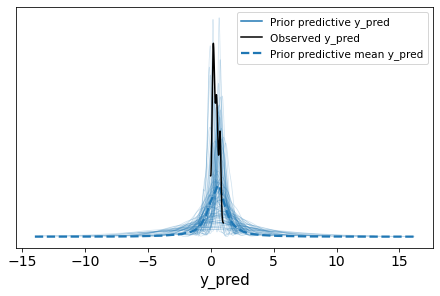

In [48]:
Pc.fit(p1 = (4, 3), p2 = (12, 5), p1_mode = "multiplicative", p2_mode = "multiplicative")

In [49]:
Pc.sample_mod()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, alpha, beta_line, beta_p2_waves, p2, beta_p1_waves, p1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 270 seconds.


0, dim: idx, 228 =? 228


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
C:\Users\Mikkel\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


posterior predictive variable y_pred's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


0, dim: idx, 228 =? 228


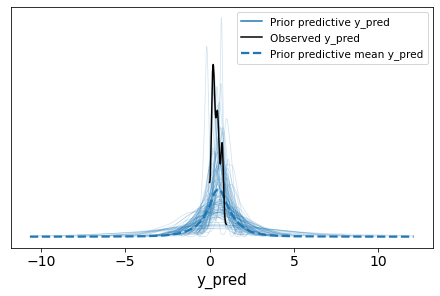

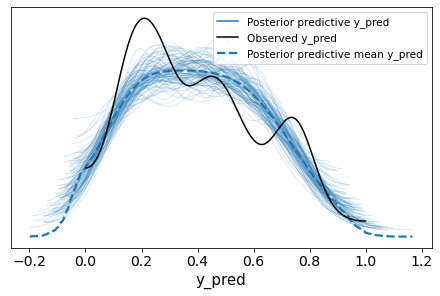

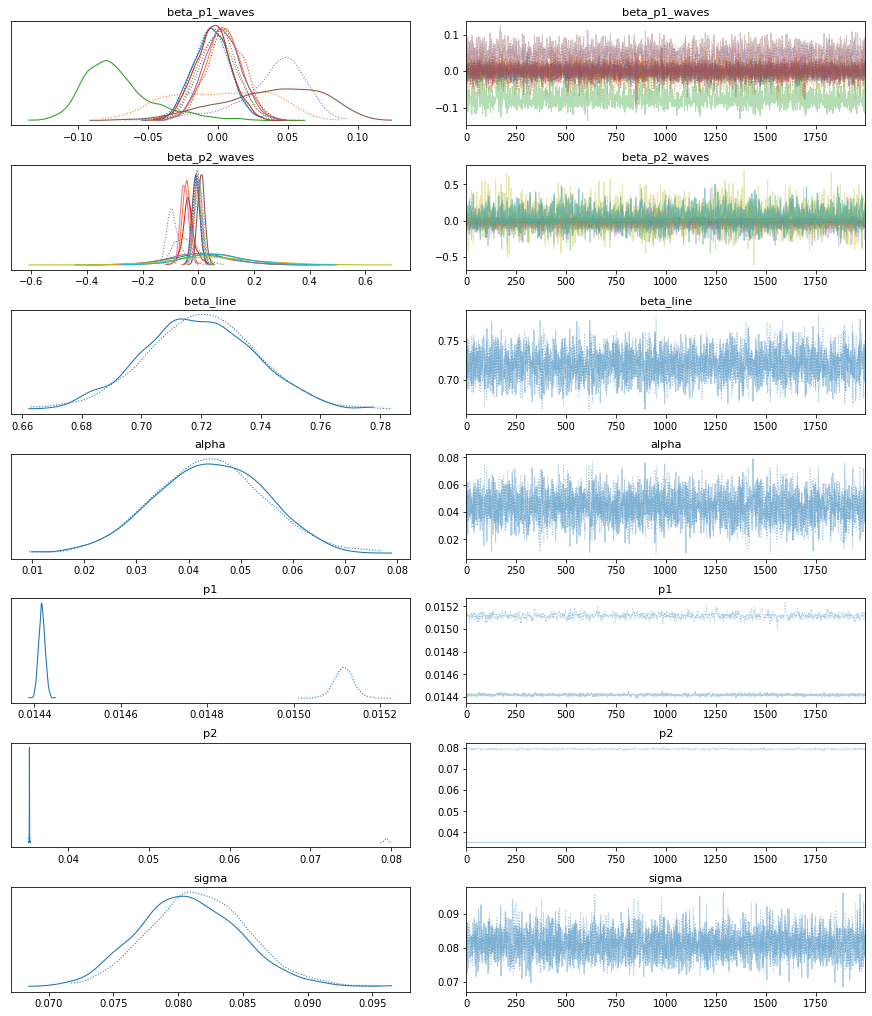

In [50]:
Pc.plotting()

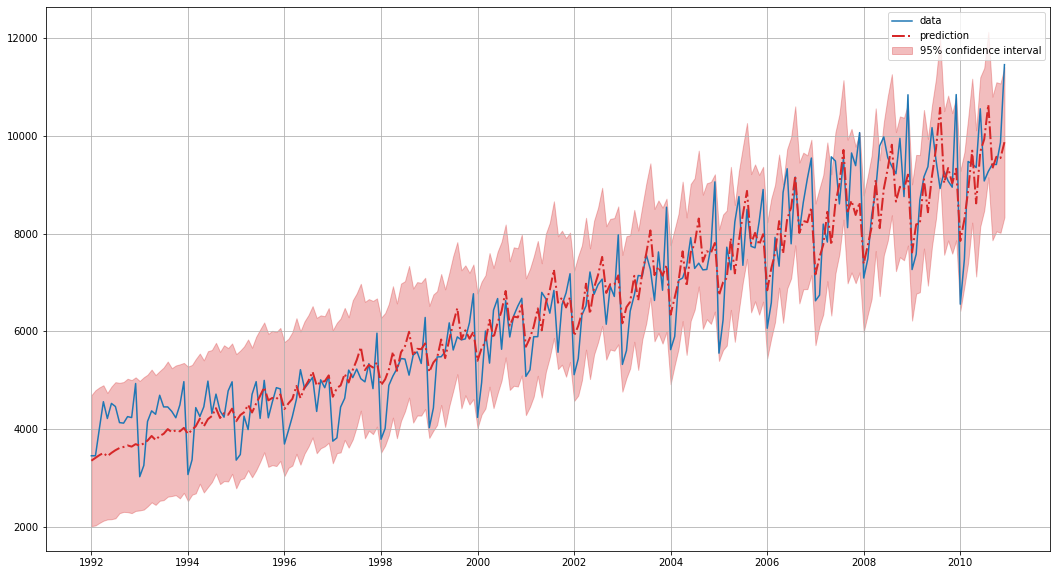

In [51]:
Pc.plot_train_idx()

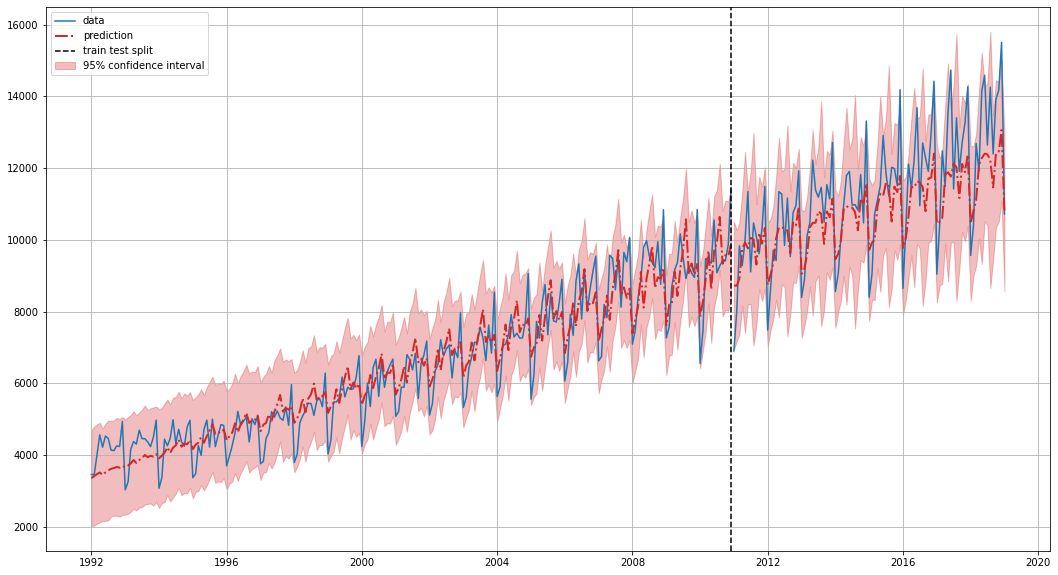

In [52]:
Pc.predict()

In [ ]:
def acccuracy(trace, model):
    train_accuracy =
    test_accuracy = 